In [ ]:

# ============================================================================
# COMPLETE CKD ANALYSIS PIPELINE (WITH COMBINED AUC PLOT)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# UPDATED IMPORT: Added RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION: Set total number of rows here
# ============================================================================
# UPDATED: Increased to 2000 to make the curves look smooth and professional
TOTAL_ROWS = 2000

# ============================================================================
# PART 1: GENERATING SYNTHETIC CKD DATASET
# ============================================================================
print("=" * 80)
print("PART 1: GENERATING SYNTHETIC CKD DATASET")
print("=" * 80)

# Set random seed for reproducibility
np.random.seed(42)

# Calculate rows per class (50-50 split)
n_ckd = TOTAL_ROWS // 2
n_healthy = TOTAL_ROWS // 2

print(f"\nDataset created with {TOTAL_ROWS} rows ({n_ckd} CKD, {n_healthy} healthy)")

# Generate CKD patients
age_ckd = np.random.normal(55, 4, n_ckd).astype(int)
serum_creatinine_ckd = np.random.normal(2.8, 0.8, n_ckd)  # mg/dL - elevated in CKD
hemoglobin_ckd = np.random.normal(10, 2, n_ckd)  # g/dL - low in CKD
diabetes_ckd = np.random.choice(['yes', 'no'], n_ckd, p=[0.7, 0.3])
class_ckd = ['ckd'] * n_ckd

# Generate healthy patients
age_healthy = np.random.normal(50, 4, n_healthy).astype(int)
serum_creatinine_healthy = np.random.normal(1.8, 0.5, n_healthy)  # mg/dL - normal range
hemoglobin_healthy = np.random.normal(14, 2, n_healthy)  # g/dL - normal range
diabetes_healthy = np.random.choice(['yes', 'no'], n_healthy, p=[0.2, 0.8])
class_healthy = ['healthy'] * n_healthy

# Combine all data
data = {
    'age': np.concatenate([age_ckd, age_healthy]),
    'serum_creatinine': np.concatenate([serum_creatinine_ckd, serum_creatinine_healthy]),
    'hemoglobin': np.concatenate([hemoglobin_ckd, hemoglobin_healthy]),
    'diabetes': np.concatenate([diabetes_ckd, diabetes_healthy]),
    'class': np.concatenate([class_ckd, class_healthy])
}

df = pd.DataFrame(data)






# Create your dataframe
df = pd.DataFrame(data)

# Add the new row to simulate an error in input
Impossible_row = {
    'age': 45,
    'serum_creatinine': 2.4,
    'hemoglobin': 1,
    'diabetes': 'yes',
    'class': 'ckd'
}

df = pd.concat([df, pd.DataFrame([Impossible_row])], ignore_index=True)


# Insert missing values (marked as '?')
missing_indices = np.random.choice(df.index, size=int(0.1 * len(df) * 3), replace=False)
missing_count = 0
for idx in missing_indices:
    col = np.random.choice(['age', 'serum_creatinine', 'hemoglobin'])
    df.at[idx, col] = '?'
    missing_count += 1

print(f"Units: age (years), serum_creatinine (mg/dL), hemoglobin (g/dL)")
print(f"Missing values marked as '?' inserted: {missing_count} cells")

# Save to CSV
df.to_csv('ckd_dataset.csv', index=False)
print("\nSaved CSV file: ckd_dataset.csv")

print("\n" + "-" * 80)
print("HEAD OF DATASET (first 5 rows):")
print("-" * 80)
print(df.head())

print("\n" + "-" * 80)
print("TAIL OF DATASET (last 5 rows):")
print("-" * 80)
print(df.tail())

# ============================================================================
# PART 2: LOADING AND PREPROCESSING DATA
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 2: LOADING AND PREPROCESSING DATA")
print("=" * 80)

df = pd.read_csv('ckd_dataset.csv')
print(f"\nLoaded dataset from: ckd_dataset.csv")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)
print("\nReplaced '?' with NaN values")

# Convert to numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['serum_creatinine'] = pd.to_numeric(df['serum_creatinine'], errors='coerce')
df['hemoglobin'] = pd.to_numeric(df['hemoglobin'], errors='coerce')

print("\nConverted age, serum_creatinine, hemoglobin to numeric type")
print("Kept diabetes as categorical (yes/no)")

print("\n" + "-" * 80)
print("DATA TYPES:")
print("-" * 80)
print(df.dtypes)

print("\n" + "-" * 80)
print("DESCRIPTIVE STATISTICS (all numeric columns):")
print("-" * 80)
print(df.describe())
print("\nThe describe() shows count, mean, std, min, 25%, 50%, 75%, max")
print("Count shows number of non-missing values per column")
print("Mean and std show central tendency and spread")

print("\n" + "-" * 80)
print("MISSING VALUES COUNT:")
print("-" * 80)
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# ============================================================================
# PART 3: EXPLORATORY DATA ANALYSIS
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 3: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Boxplots for numerical features by class
for col in ['age', 'serum_creatinine', 'hemoglobin']:
    plt.figure(figsize=(8, 6))
    df.boxplot(column=col, by='class')
    plt.suptitle('')
    plt.title(f'Boxplot of {col} by Class')
    plt.ylabel(col)
    filename = f'boxplot_{col}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"\nSaved boxplot: {filename}")

# Scatter plot
plt.figure(figsize=(10, 6))
for cls in df['class'].unique():
    subset = df[df['class'] == cls]
    plt.scatter(subset['serum_creatinine'], subset['hemoglobin'], label=cls, alpha=0.6)
plt.xlabel('Serum Creatinine (mg/dL)')
plt.ylabel('Hemoglobin (g/dL)')
plt.title('Serum Creatinine vs Hemoglobin')
plt.legend()
plt.savefig('scatter_creatinine_hemoglobin.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved scatter plot: scatter_creatinine_hemoglobin.png")

#full visual
import seaborn as sns
import matplotlib.pyplot as plt

print("Generating Age vs Class Scatter (No Loop)...")

plt.figure(figsize=(10, 6))

# 'hue' automatically assigns different colors to the classes without a loop
sns.scatterplot(data=df, x='class', y='age', hue='class', alpha=0.6, s=100)

plt.xlabel('Class')
plt.ylabel('Age')
plt.title('Age vs Class')

# Save it
plt.savefig('scatter_age_class.png', dpi=300, bbox_inches='tight')
plt.close()

print("Saved: scatter_age_class.png")


import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. HEMOGLOBIN vs CLASS
# ==========================================
print("Generating Hemoglobin Strip Plot...")
plt.figure(figsize=(8, 6))

sns.stripplot(data=df, x='class', y='hemoglobin', hue='class', jitter=0.2, size=4, alpha=0.7)

plt.title('Hemoglobin vs Class (Individual Observations)')
plt.xlabel('Class')
plt.ylabel('Hemoglobin')

plt.savefig('scatter_hemoglobin_class.png', dpi=300, bbox_inches='tight')
plt.close() # Clear memory for the next plot
print("Saved: scatter_hemoglobin_class.png")

#one outlier hem 1 decision to remove.it

#we will remove it in the preprocess chapter
print("decision to remove the onservation hemoglobin 1")
# ==========================================
# 2. SERUM CREATININE vs CLASS
# ==========================================
print("Generating Serum Creatinine Strip Plot...")
plt.figure(figsize=(8, 6))

# Note: Check if your column is named 'serum_creatinine' or 'sc'
sns.stripplot(data=df, x='class', y='serum_creatinine', hue='class', jitter=0.2, size=4, alpha=0.7)

plt.title('Serum Creatinine vs Class (Individual Observations)')
plt.xlabel('Class')
plt.ylabel('Serum Creatinine')

plt.savefig('scatter_creatinine_class.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: scatter_creatinine_class.png")





# Frequency plot for diabetes
plt.figure(figsize=(10, 6))
df.groupby(['diabetes', 'class']).size().unstack().plot(kind='bar')
plt.title('Diabetes Status by Class')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Class')
plt.savefig('frequency_diabetes.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved frequency plot: frequency_diabetes.png")

# ============================================================================
# PART 4: STATISTICAL TESTS
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 4: STATISTICAL TESTS")
print("=" * 80)

print("\nT-test compares means between two groups")
print("Null hypothesis: means are equal between CKD and healthy")
print("P-value < 0.05 indicates significant difference")

# T-tests for numerical features
for col in ['age', 'serum_creatinine', 'hemoglobin']:
    ckd_data = df[df['class'] == 'ckd'][col].dropna()
    healthy_data = df[df['class'] == 'healthy'][col].dropna()

    t_stat, p_value = stats.ttest_ind(ckd_data, healthy_data)

    print("\n" + "-" * 80)
    print(f"T-TEST FOR {col.upper()}:")
    print("-" * 80)
    print(f"CKD mean: {ckd_data.mean():.2f}")
    print(f"Healthy mean: {healthy_data.mean():.2f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Result: {'Significant difference' if p_value < 0.05 else 'No significant difference'} (p {'<' if p_value < 0.05 else '>='} 0.05)")

# Chi-square test for diabetes
contingency_table = pd.crosstab(df['diabetes'], df['class'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("\n" + "-" * 80)
print("CHI-SQUARE TEST FOR DIABETES:")
print("-" * 80)
print("Chi-square tests association between categorical variables")
print("Null hypothesis: no association between diabetes and CKD")
print("P-value < 0.05 indicates significant association")
print("\nContingency Table:")
print(contingency_table)
print(f"\nChi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value:.4f}")
print(f"Result: {'Significant association' if p_value < 0.05 else 'No significant association'} (p {'<' if p_value < 0.05 else '>='} 0.05)")

# ============================================================================
# PART 5: DATA CLEANING
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 5: DATA CLEANING")
print("=" * 80)

# Remove unrealistic values
print("\nDecision: Remove rows with hemoglobin < 2 g/dL (unrealistic values)")
rows_before = len(df)
df = df[~((df['hemoglobin'] < 2) & (df['hemoglobin'].notna()))]
rows_after = len(df)
print(f"Rows before: {rows_before}")
print(f"Rows after: {rows_after}")
print(f"Rows removed: {rows_before - rows_after}")

# Remove missing values
print("\nDecision: Remove rows with any missing values")
rows_before = len(df)
df = df.dropna()
rows_after = len(df)
print(f"Rows before: {rows_before}")
print(f"Rows after: {rows_after}")
print(f"Rows removed: {rows_before - rows_after}")

print("\n" + "-" * 80)
print("FINAL CLEANED DATASET:")
print("-" * 80)
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()}")
print("\nDataset ready for machine learning")

print("\n" + "-" * 80)
print("CLASS DISTRIBUTION IN CLEANED DATASET:")
print("-" * 80)
print(df['class'].value_counts())
print(f"\nCKD: {(df['class'] == 'ckd').sum()} patients")
print(f"Healthy: {(df['class'] == 'healthy').sum()} patients")

# ============================================================================
# PART 6: PREPARE DATA FOR MACHINE LEARNING
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 6: PREPARE DATA FOR MACHINE LEARNING")
print("=" * 80)

# Encode categorical variables
df['diabetes_encoded'] = df['diabetes'].map({'yes': 1, 'no': 0})
df['class_encoded'] = df['class'].map({'ckd': 1, 'healthy': 0})

print("\nEncoded diabetes: yes=1, no=0")
print("Encoded class: ckd=1 (positive), healthy=0 (negative)")

# Prepare features and target
X = df[['age', 'serum_creatinine', 'hemoglobin', 'diabetes_encoded']].values
y = df['class_encoded'].values

print(f"\nFeature matrix X shape: {X.shape}")
print(f"Target vector y shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n" + "-" * 80)
print("TRAIN-TEST SPLIT (80%-20%):")
print("-" * 80)
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Training set - CKD: {sum(y_train)} / Healthy: {len(y_train) - sum(y_train)}")
print(f"Test set - CKD: {sum(y_test)} / Healthy: {len(y_test) - sum(y_test)}")
print("\nRandom state = 42 for reproducibility")

# ============================================================================
# PART 7: DECISION TREE CLASSIFIER
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 7: DECISION TREE CLASSIFIER")
print("=" * 80)

# Train decision tree
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

print("\nDecision Tree trained on training set")
print(f"Max depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")

# Plot tree structure
plt.figure(figsize=(15, 10))
plot_tree(dt_model, feature_names=['Age', 'Creatinine', 'Hemoglobin', 'Diabetes'],
          class_names=['Healthy', 'CKD'], filled=True, fontsize=10)
plt.savefig('decision_tree_structure.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved tree structure: decision_tree_structure.png")

# Predictions
# 1. Hard predictions (0 or 1)
y_pred_dt = dt_model.predict(X_test)

# 2. Probability predictions (0.0 to 1.0) - CRITICAL FOR AUC
# We take column [:, 1] for the positive class (CKD)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print("\nPredictions made on test set")

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()

print("\n" + "-" * 80)
print("CONFUSION MATRIX - DECISION TREE:")
print("-" * 80)
print("          Predicted")
print("          Healthy  CKD")
print(f"Actual Healthy   {tn_dt:4d}   {fp_dt:4d}")
print(f"       CKD       {fn_dt:4d}   {tp_dt:4d}")

print("\n" + "-" * 80)
print("CONFUSION MATRIX ELEMENTS:")
print("-" * 80)
print(f"True Negative (TN):  {tn_dt}")
print(f"False Positive (FP): {fp_dt}")
print(f"False Negative (FN): {fn_dt}")
print(f"True Positive (TP):  {tp_dt}")

# Calculate metrics
accuracy_dt = (tp_dt + tn_dt) / (tp_dt + tn_dt + fp_dt + fn_dt)
sensitivity_dt = tp_dt / (tp_dt + fn_dt) if (tp_dt + fn_dt) > 0 else 0
specificity_dt = tn_dt / (tn_dt + fp_dt) if (tn_dt + fp_dt) > 0 else 0
ppv_dt = tp_dt / (tp_dt + fp_dt) if (tp_dt + fp_dt) > 0 else 0
npv_dt = tn_dt / (tn_dt + fn_dt) if (tn_dt + fn_dt) > 0 else 0
f1_dt = 2 * (ppv_dt * sensitivity_dt) / (ppv_dt + sensitivity_dt) if (ppv_dt + sensitivity_dt) > 0 else 0

print("\n" + "-" * 80)
print("PERFORMANCE METRICS:")
print("-" * 80)
print(f"Accuracy:    {accuracy_dt:.4f}  (TP+TN)/(TP+TN+FP+FN)")
print(f"Sensitivity: {sensitivity_dt:.4f}  TP/(TP+FN) - recall, true positive rate")
print(f"Specificity: {specificity_dt:.4f}  TN/(TN+FP) - true negative rate")
print(f"PPV:         {ppv_dt:.4f}  TP/(TP+FP) - positive predictive value, precision")
print(f"NPV:         {npv_dt:.4f}  TN/(TN+FN) - negative predictive value")
print(f"F1 Score:    {f1_dt:.4f}  2*(PPV*Sensitivity)/(PPV+Sensitivity)")

# ROC curve
# Use probabilities (y_pred_proba_dt) not hard predictions
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
auc_dt = auc(fpr_dt, tpr_dt)

print("\n" + "-" * 80)
print("ROC-AUC ANALYSIS:")
print("-" * 80)
print("ROC curve shows trade-off between sensitivity and specificity")
print("X-axis: False Positive Rate (1-Specificity)")
print("Y-axis: True Positive Rate (Sensitivity)")
print("AUC = Area Under Curve: 1.0 = perfect, 0.5 = random")
print(f"\nAUC Score: {auc_dt:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_decision_tree.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved ROC curve: roc_curve_decision_tree.png")

# ============================================================================
# PART 8: RANDOM FOREST CLASSIFIER
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 8: RANDOM FOREST CLASSIFIER")
print("=" * 80)

# Train random forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

print("\nRandom Forest trained on training set")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Number of features: {rf_model.n_features_in_}")

# Feature importance
feature_names = ['Age', 'Creatinine', 'Hemoglobin', 'Diabetes']
importances = rf_model.feature_importances_

print("\n" + "-" * 80)
print("FEATURE IMPORTANCE:")
print("-" * 80)
for name, importance in zip(feature_names, importances):
    print(f"{name:15s}: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.savefig('random_forest_importance.png', dpi=300, bbox_inches='tight')
plt.close()
print("\nSaved feature importance: random_forest_importance.png")

# Predictions
# 1. Hard predictions
y_pred_rf = rf_model.predict(X_test)

# 2. Probability predictions - CRITICAL FOR AUC
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nPredictions made on test set")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

print("\n" + "-" * 80)
print("CONFUSION MATRIX - RANDOM FOREST:")
print("-" * 80)
print("          Predicted")
print("          Healthy  CKD")
print(f"Actual Healthy   {tn_rf:4d}   {fp_rf:4d}")
print(f"       CKD       {fn_rf:4d}   {tp_rf:4d}")

print("\n" + "-" * 80)
print("CONFUSION MATRIX ELEMENTS:")
print("-" * 80)
print(f"True Negative (TN):  {tn_rf}")
print(f"False Positive (FP): {fp_rf}")
print(f"False Negative (FN): {fn_rf}")
print(f"True Positive (TP):  {tp_rf}")

# Calculate metrics
accuracy_rf = (tp_rf + tn_rf) / (tp_rf + tn_rf + fp_rf + fn_rf)
sensitivity_rf = tp_rf / (tp_rf + fn_rf) if (tp_rf + fn_rf) > 0 else 0
specificity_rf = tn_rf / (tn_rf + fp_rf) if (tn_rf + fp_rf) > 0 else 0
ppv_rf = tp_rf / (tp_rf + fp_rf) if (tp_rf + fp_rf) > 0 else 0
npv_rf = tn_rf / (tn_rf + fn_rf) if (tn_rf + fn_rf) > 0 else 0
f1_rf = 2 * (ppv_rf * sensitivity_rf) / (ppv_rf + sensitivity_rf) if (ppv_rf + sensitivity_rf) > 0 else 0

print("\n" + "-" * 80)
print("PERFORMANCE METRICS:")
print("-" * 80)
print(f"Accuracy:    {accuracy_rf:.4f}  (TP+TN)/(TP+TN+FP+FN)")
print(f"Sensitivity: {sensitivity_rf:.4f}  TP/(TP+FN) - recall, true positive rate")
print(f"Specificity: {specificity_rf:.4f}  TN/(TN+FP) - true negative rate")
print(f"PPV:         {ppv_rf:.4f}  TP/(TP+FP) - positive predictive value, precision")
print(f"NPV:         {npv_rf:.4f}  TN/(TN+FN) - negative predictive value")
print(f"F1 Score:    {f1_rf:.4f}  2*(PPV*Sensitivity)/(PPV+Sensitivity)")

# ROC curve
# Use probabilities (y_pred_proba_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

print("\n" + "-" * 80)
print("ROC-AUC ANALYSIS:")
print("-" * 80)
print("ROC curve shows trade-off between sensitivity and specificity")
print("X-axis: False Positive Rate (1-Specificity)")
print("Y-axis: True Positive Rate (Sensitivity)")
print("AUC = Area Under Curve: 1.0 = perfect, 0.5 = random")
print(f"\nAUC Score: {auc_rf:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_random_forest.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved ROC curve: roc_curve_random_forest.png")

# ============================================================================
# PART 9: NEURAL NETWORK CLASSIFIER
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 9: NEURAL NETWORK CLASSIFIER")
print("=" * 80)

# Train neural network
nn_model = MLPClassifier(hidden_layer_sizes=(4,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)

print("\nNeural Network trained on training set")
print(f"Hidden layer sizes: {nn_model.hidden_layer_sizes}")
print(f"Number of layers: {nn_model.n_layers_}")
print(f"Number of iterations: {nn_model.n_iter_}")
print(f"Activation function: {nn_model.activation}")

print("\n" + "-" * 80)
print("NETWORK STRUCTURE:")
print("-" * 80)
print(f"Input layer:  {X_train.shape[1]} nodes (age, creatinine, hemoglobin, diabetes)")
print(f"Hidden layer: {nn_model.hidden_layer_sizes[0]} nodes")
print(f"Output layer: 1 node (CKD probability)")
print(f"Total: {nn_model.n_layers_} layers")

# Simple visualization
fig, ax = plt.subplots(figsize=(10, 6))
layer_sizes = [X_train.shape[1]] + list(nn_model.hidden_layer_sizes) + [1]
v_spacing = 1.0 / max(layer_sizes)
h_spacing = 1.0 / (len(layer_sizes) - 1)

for i, layer_size in enumerate(layer_sizes):
    layer_top = v_spacing * (layer_size - 1) / 2 + 0.5
    for j in range(layer_size):
        circle = plt.Circle((i * h_spacing, layer_top - j * v_spacing),
                           v_spacing / 4, color='skyblue', ec='black', zorder=4)
        ax.add_artist(circle)

        if i == 0:
            label = ['Age', 'Creat', 'Hemo', 'Diab'][j]
            plt.text(i * h_spacing - 0.1, layer_top - j * v_spacing, label,
                    fontsize=9, ha='right')

        if i < len(layer_sizes) - 1:
            for k in range(layer_sizes[i + 1]):
                next_layer_top = v_spacing * (layer_sizes[i + 1] - 1) / 2 + 0.5
                plt.plot([i * h_spacing, (i + 1) * h_spacing],
                        [layer_top - j * v_spacing, next_layer_top - k * v_spacing],
                        'gray', alpha=0.3, zorder=1)

ax.axis('off')
plt.title('Neural Network Structure')
plt.savefig('neural_network_structure.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved network structure: neural_network_structure.png")

# Predictions
# 1. Hard predictions
y_pred_nn = nn_model.predict(X_test)

# 2. Probability predictions - CRITICAL FOR AUC
y_pred_proba_nn = nn_model.predict_proba(X_test)[:, 1]

print("\nPredictions made on test set")

# Confusion matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
tn_nn, fp_nn, fn_nn, tp_nn = cm_nn.ravel()

print("\n" + "-" * 80)
print("CONFUSION MATRIX - NEURAL NETWORK:")
print("-" * 80)
print("          Predicted")
print("          Healthy  CKD")
print(f"Actual Healthy   {tn_nn:4d}   {fp_nn:4d}")
print(f"       CKD       {fn_nn:4d}   {tp_nn:4d}")

print("\n" + "-" * 80)
print("CONFUSION MATRIX ELEMENTS:")
print("-" * 80)
print(f"True Negative (TN):  {tn_nn}")
print(f"False Positive (FP): {fp_nn}")
print(f"False Negative (FN): {fn_nn}")
print(f"True Positive (TP):  {tp_nn}")

# Calculate metrics
accuracy_nn = (tp_nn + tn_nn) / (tp_nn + tn_nn + fp_nn + fn_nn)
sensitivity_nn = tp_nn / (tp_nn + fn_nn) if (tp_nn + fn_nn) > 0 else 0
specificity_nn = tn_nn / (tn_nn + fp_nn) if (tn_nn + fp_nn) > 0 else 0
ppv_nn = tp_nn / (tp_nn + fp_nn) if (tp_nn + fp_nn) > 0 else 0
npv_nn = tn_nn / (tn_nn + fn_nn) if (tn_nn + fn_nn) > 0 else 0
f1_nn = 2 * (ppv_nn * sensitivity_nn) / (ppv_nn + sensitivity_nn) if (ppv_nn + sensitivity_nn) > 0 else 0

print("\n" + "-" * 80)
print("PERFORMANCE METRICS:")
print("-" * 80)
print(f"Accuracy:    {accuracy_nn:.4f}  (TP+TN)/(TP+TN+FP+FN)")
print(f"Sensitivity: {sensitivity_nn:.4f}  TP/(TP+FN) - recall, true positive rate")
print(f"Specificity: {specificity_nn:.4f}  TN/(TN+FP) - true negative rate")
print(f"PPV:         {ppv_nn:.4f}  TP/(TP+FP) - positive predictive value, precision")
print(f"NPV:         {npv_nn:.4f}  TN/(TN+FN) - negative predictive value")
print(f"F1 Score:    {f1_nn:.4f}  2*(PPV*Sensitivity)/(PPV+Sensitivity)")

# ROC curve
# Use probabilities (y_pred_proba_nn)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn)
auc_nn = auc(fpr_nn, tpr_nn)

print("\n" + "-" * 80)
print("ROC-AUC ANALYSIS:")
print("-" * 80)
print("ROC curve shows trade-off between sensitivity and specificity")
print("X-axis: False Positive Rate (1-Specificity)")
print("Y-axis: True Positive Rate (Sensitivity)")
print("AUC = Area Under Curve: 1.0 = perfect, 0.5 = random")
print(f"\nAUC Score: {auc_nn:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_neural_network.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved ROC curve: roc_curve_neural_network.png")

# ============================================================================
# PART 10: MODEL COMPARISON
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 10: MODEL COMPARISON")
print("=" * 80)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'Neural Network'],
    'Accuracy': [accuracy_dt, accuracy_rf, accuracy_nn],
    'Sensitivity': [sensitivity_dt, sensitivity_rf, sensitivity_nn],
    'Specificity': [specificity_dt, specificity_rf, specificity_nn],
    'PPV': [ppv_dt, ppv_rf, ppv_nn],
    'NPV': [npv_dt, npv_rf, npv_nn],
    'F1_Score': [f1_dt, f1_rf, f1_nn],
    'AUC': [auc_dt, auc_rf, auc_nn]
})

print("\n" + "-" * 80)
print("COMPARISON TABLE - ALL MODELS:")
print("-" * 80)
print(comparison.to_string(index=False))

print("\n" + "-" * 80)
print("BEST PERFORMING MODEL BY METRIC:")
print("-" * 80)
print(f"Highest Accuracy:    {comparison.loc[comparison['Accuracy'].idxmax(), 'Model']}")
print(f"Highest Sensitivity: {comparison.loc[comparison['Sensitivity'].idxmax(), 'Model']}")
print(f"Highest Specificity: {comparison.loc[comparison['Specificity'].idxmax(), 'Model']}")
print(f"Highest AUC:         {comparison.loc[comparison['AUC'].idxmax(), 'Model']}")
print(f"Highest F1 Score:    {comparison.loc[comparison['F1_Score'].idxmax(), 'Model']}")

# Plot comparison bar charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'AUC']
for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.bar(comparison['Model'], comparison[metric], color=['skyblue', 'lightgreen', 'lightcoral'])
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print("\nSaved comparison chart: model_comparison.png")

# ============================================================================
# NEW: COMBINED ROC CURVE PLOT (USING SKLEARN ROCCURVEDISPLAY)
# ============================================================================
print("\nGenerating combined ROC curve plot (using RocCurveDisplay)...")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# 1. Plot Decision Tree
RocCurveDisplay.from_estimator(
    dt_model, X_test, y_test,
    name="Decision Tree",
    ax=ax,
    linewidth=2
)

# 2. Plot Random Forest
RocCurveDisplay.from_estimator(
    rf_model, X_test, y_test,
    name="Random Forest",
    ax=ax,
    linewidth=2
)

# 3. Plot Neural Network
RocCurveDisplay.from_estimator(
    nn_model, X_test, y_test,
    name="Neural Network",
    ax=ax,
    linewidth=2
)

# 4. Add the "Random Guess" dashed line
plt.plot([0, 1], [0, 1], 'k--', label='Random Probability (AUC = 0.5)', alpha=0.5)

# Formatting
plt.title('ROC Curve Comparison - All Models', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right", fontsize=12)

# Save
plt.tight_layout()
plt.savefig('1roc_curve_comparison_all.png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved combined ROC plot: roc_curve_comparison_all.png")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

print("\nGenerated files:")
print("  CSV: ckd_dataset.csv")
print("  Boxplots: boxplot_age.png, boxplot_serum_creatinine.png, boxplot_hemoglobin.png")
print("  Scatter: scatter_creatinine_hemoglobin.png")
print("  Frequency: frequency_diabetes.png")
print("  Decision Tree: decision_tree_structure.png, roc_curve_decision_tree.png")
print("  Random Forest: random_forest_importance.png, roc_curve_random_forest.png")
print("  Neural Network: neural_network_structure.png, roc_curve_neural_network.png")
print("  Comparison: model_comparison.png")
print("  Combined ROC: roc_curve_comparison_all.png")
print("\nAll results printed to console for documentation")

PART 1: GENERATING SYNTHETIC CKD DATASET

Dataset created with 2000 rows (1000 CKD, 1000 healthy)
Units: age (years), serum_creatinine (mg/dL), hemoglobin (g/dL)
Missing values marked as '?' inserted: 600 cells

Saved CSV file: ckd_dataset.csv

--------------------------------------------------------------------------------
HEAD OF DATASET (first 5 rows):
--------------------------------------------------------------------------------
  age serum_creatinine hemoglobin diabetes class
0  56         3.919484   8.649643       no   ckd
1  54         3.539707   9.710963       no   ckd
2  57         2.847704    8.41516      yes   ckd
3  61                ?   9.384077       no   ckd
4  54         3.358579   6.212771      yes   ckd

--------------------------------------------------------------------------------
TAIL OF DATASET (last 5 rows):
--------------------------------------------------------------------------------
     age serum_creatinine hemoglobin diabetes    class
1996  61         1

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
!pip install networkx

In [ ]:
# ============================================================================
# PART 11: SIMPLIFIED VISUALIZATION USING NETWORKX LIBRARY
# ============================================================================
!pip install networkx
import networkx as nx

print("\n\n" + "=" * 80)
print("PART 11: NEURAL NET VISUALIZATION (NETWORKX LIBRARY)")
print("=" * 80)

def plot_net_with_library(model, feature_names):
    # 1. Initialize the Graph Object
    G = nx.DiGraph()

    # 2. Get the weights from the model
    # weights[0] connects Input -> Hidden
    # weights[1] connects Hidden -> Output
    weights = model.coefs_

    # 3. Define the structure
    input_nodes = feature_names
    hidden_nodes = [f"H{i+1}" for i in range(weights[0].shape[1])]
    output_nodes = ["Output"]

    # 4. Add nodes to the graph with a "subset" attribute (used for layers)
    # Layer 0: Inputs
    for i, node in enumerate(input_nodes):
        G.add_node(node, subset=0, color='lightgray')

    # Layer 1: Hidden
    for i, node in enumerate(hidden_nodes):
        G.add_node(node, subset=1, color='lightyellow')

    # Layer 2: Output
    for i, node in enumerate(output_nodes):
        G.add_node(node, subset=2, color='lightgreen')

    # 5. Add Edges (Connections) based on weights
    # Input -> Hidden
    for i, input_node in enumerate(input_nodes):
        for j, hidden_node in enumerate(hidden_nodes):
            w = weights[0][i][j]
            # Color edge red if negative, blue if positive
            col = 'red' if w < 0 else 'blue'
            # Add edge with weight info
            G.add_edge(input_node, hidden_node, weight=abs(w), color=col)

    # Hidden -> Output
    for i, hidden_node in enumerate(hidden_nodes):
        for j, output_node in enumerate(output_nodes):
            w = weights[1][i][j]
            col = 'red' if w < 0 else 'blue'
            G.add_edge(hidden_node, output_node, weight=abs(w), color=col)

    # 6. DRAWING
    plt.figure(figsize=(12, 8))

    # Use the library's layout engine to place nodes in layers automatically
    pos = nx.multipartite_layout(G, subset_key="subset")

    # Extract edge colors and widths
    edges = G.edges()
    colors = [G[u][v]['color'] for u, v in edges]
    widths = [G[u][v]['weight'] * 2 for u, v in edges] # Multiply by 2 for visibility

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=['lightgray']*len(input_nodes) + ['#ffffcc']*len(hidden_nodes) + ['#ccffcc']*len(output_nodes), edgecolors='black')

    # Draw Labels
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw Edges
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=widths, arrowstyle='->', arrowsize=20)

    plt.title("Neural Network Structure (Generated by NetworkX)", fontsize=15)
    plt.axis('off')
    plt.savefig('neural_network_library_view.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Saved: neural_network_library_view.png")

# Run it
feature_names_list = ['Age', 'Creat', 'Hemo', 'Diab']
plot_net_with_library(nn_model, feature_names_list)

# ============================================================================
# PART 12: DECISION TREE GINI & PARAMETERS (TEXT OUTPUT)
# ============================================================================
print("\n\n" + "=" * 80)
print("PART 12: DECISION TREE PARAMETERS")
print("=" * 80)

# This is the built-in way to get the text representation
from sklearn.tree import export_text

# 1. Get the rules in a simple text format
tree_rules = export_text(dt_model, feature_names=['Age', 'Creatinine', 'Hemoglobin', 'Diabetes'])

print("DECISION TREE RULES:")
print(tree_rules)

# 2. Get the Gini importance (Feature Importance)
print("\nGINI IMPORTANCE (Which features mattered most?):")
for name, importance in zip(['Age', 'Creatinine', 'Hemoglobin', 'Diabetes'], dt_model.feature_importances_):
    print(f"{name:12s}: {importance:.4f}")

# 3. Get Parameters
print("\nMODEL PARAMETERS:")
print(f"Criterion: {dt_model.criterion} (The metric used, usually Gini)")
print(f"Max Depth: {dt_model.max_depth}")
print(f"Splitter:  {dt_model.splitter}")



PART 11: NEURAL NET VISUALIZATION (NETWORKX LIBRARY)
Saved: neural_network_library_view.png


PART 12: DECISION TREE PARAMETERS
DECISION TREE RULES:
|--- Hemoglobin <= 11.92
|   |--- Creatinine <= 2.03
|   |   |--- Age <= 52.50
|   |   |   |--- class: 0
|   |   |--- Age >  52.50
|   |   |   |--- class: 1
|   |--- Creatinine >  2.03
|   |   |--- Hemoglobin <= 10.99
|   |   |   |--- class: 1
|   |   |--- Hemoglobin >  10.99
|   |   |   |--- class: 1
|--- Hemoglobin >  11.92
|   |--- Creatinine <= 2.76
|   |   |--- Age <= 55.50
|   |   |   |--- class: 0
|   |   |--- Age >  55.50
|   |   |   |--- class: 0
|   |--- Creatinine >  2.76
|   |   |--- Age <= 49.50
|   |   |   |--- class: 0
|   |   |--- Age >  49.50
|   |   |   |--- class: 1


GINI IMPORTANCE (Which features mattered most?):
Age         : 0.1082
Creatinine  : 0.2132
Hemoglobin  : 0.6785
Diabetes    : 0.0000

MODEL PARAMETERS:
Criterion: gini (The metric used, usually Gini)
Max Depth: 3
Splitter:  best


Generating Partial Dependence Plots...
Saved: model_behavior.png


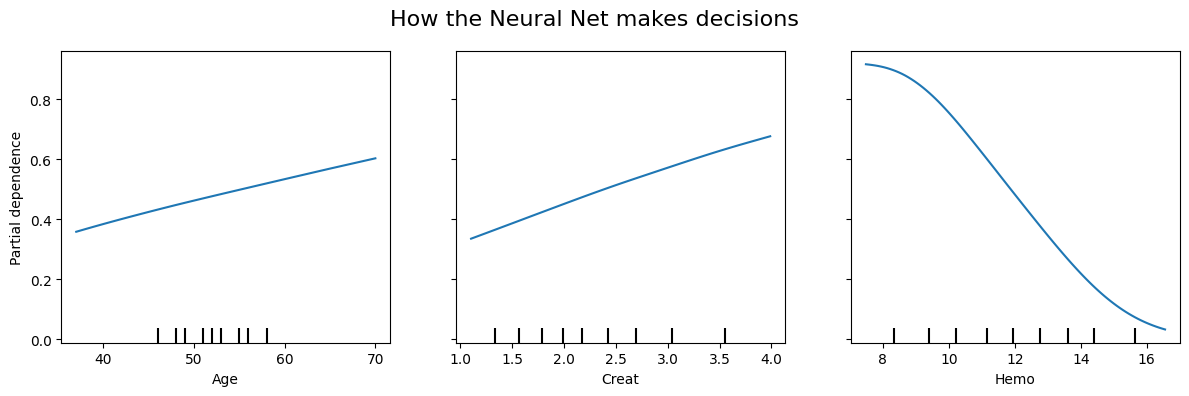

In [ ]:
# ============================================================================
# SUPER EASY VISUAL 1: HOW THE MODEL THINKS (Partial Dependence)
# ============================================================================
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

print("Generating Partial Dependence Plots...")

# One line of code to visualize the model's behavior
# We look at features 0, 1, and 2 (Age, Creatinine, Hemoglobin)
PartialDependenceDisplay.from_estimator(nn_model, X_train, [0, 1, 2], feature_names=['Age', 'Creat', 'Hemo', 'Diab'])

plt.suptitle("How the Neural Net makes decisions", fontsize=16)
plt.gcf().set_size_inches(12, 4) # Make it wide
plt.tight_layout()

# --- ADD THIS LINE TO SAVE ---
plt.savefig('model_behavior.png', dpi=300, bbox_inches='tight')
print("Saved: model_behavior.png")

plt.show()